<a href="https://colab.research.google.com/github/raqgmar/tsa4dst/blob/main/02_00_EDA_datos_procesados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Preparación del entorno.

## 0.1 Definición de parámetros

In [170]:
tfm_path='/content/drive/MyDrive/'
H1_code = 'OMNI2_H0_MRG1HR'
lookback = 12
lookforward = 2
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst'] # 'AP', out
cols_to_use2 = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst', 'ID_STORM'] # 'AP', out
cols_to_use_shift = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst', 'Dst_target', 'ID_STORM'] # 'AP', out
hstorms_data = 'historical_storms_gruet2018.csv'
gamma_value=0.0001
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas de gruet et al 2018

## 0.2 Montar Google Drive (obtención de datos)

In [171]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.3 Importación de librerías

In [172]:
import os

import numpy as np

# librerías de manipulación de datos y gráficos
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# modelo
from sklearn.svm import SVR
#from thundersvm import SVR
# escalado y división en train/test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# obtención de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error

# meta
# timer
import time

## 0.4 Definición de funciones

In [173]:
def exploracion_inicial_datos(df):
    """
    Función para realizar una exploración inicial de los datos.

    Parámetros:
    df (dataframe): El dataframe que contiene los datos.

    Muestra las primeras filas, estadísticas descriptivas, valores faltantes,
    histogramas de variables numéricas y un mapa de calor de la correlación.
    """
    # Configuración de visualización
    sns.set(style="whitegrid")  # Estilo de gráficos


    print("Primeras filas del DataFrame:")
    print(df.head())


    print("\nDescripción estadística de los datos:")
    print(df.describe())


    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


    print("\nVisualización de histogramas para variables numéricas:")
    df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
    plt.show()
    print("\nMapa de calor de la matriz de correlación:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()


def calcular_layout_optimo(num_cols):
    """
    Calcula el número óptimo de filas y columnas para una figura con subgráficos,
    tratando de mantener una forma que sea visualmente agradable y que aproveche el espacio.

    Parámetros:
    num_cols (int): Número total de columnas (gráficos) a mostrar.

    Retorna:
    (int, int): Número de filas y columnas para el layout de los subgráficos.
    """
    # Calcula el número óptimo de columnas teniendo un límite visual razonable
    cols_per_row = int(np.sqrt(num_cols)) + 1  # Ajuste para maximizar el uso del espacio y la forma de la figura
    rows_needed = (num_cols + cols_per_row - 1) // cols_per_row  # Redondeo hacia arriba para incluir todas las columnas
    return 2, 5

def exploracion_histogramas(df):
    """
    Función para generar histogramas para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear histogramas
    df_numerico.hist(bins=15, figsize=(15, 10), layout=(rows_needed, cols_per_row))
    plt.show()

def exploracion_boxplots(df):
    """
    Función para generar box-plots para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear box-plots
    fig, axes = plt.subplots(rows_needed, cols_per_row, figsize=(25, 8))
    axes = axes.flatten()

    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(y=df_numerico[col], ax=axes[i])
        axes[i].set_title(col)

    # Eliminar gráficos vacíos si existen
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def exploracion_violinplots(df):
    """
    Función para generar violin-plots para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear violin-plots
    fig, axes = plt.subplots(rows_needed, cols_per_row, figsize=(25, 8))
    axes = axes.flatten()

    for i, col in enumerate(df_numerico.columns):
        sns.violinplot(y=df_numerico[col], ax=axes[i])
        axes[i].set_title(col)

    # Eliminar gráficos vacíos si existen
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def imputar_nan(df):
  df.interpolate(method='linear', inplace=True)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  if sum(df.isnull().sum())!=0:
    print("Faltan nulos por tratar")
  return df

def visualizar_nulos_plot(df, variable_with_nans):
    """
    Plot the specified 'variable_with_nans' column and 'Dst' column from the DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data to plot.
    - variable_with_nans: str, the name of the column in the DataFrame to plot, which may contain NaNs.

    The function assumes that 'Dst' is a column name in the DataFrame and that the DataFrame's index is suitable for plotting (e.g., datetime).
    """
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 8))

    # Handling NaNs in the 'variable_with_nans' column before plotting
    df_plot = df.copy()
    df_plot[variable_with_nans] = df_plot[variable_with_nans].fillna(method='ffill')  # Forward fill to handle NaNs

    # Plotting 'variable_with_nans' on the first subplot
    ax1.scatter(df_plot.index, df_plot[variable_with_nans], label=variable_with_nans, color='blue')
    ax1.set_ylabel(variable_with_nans)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting 'Dst' on the second subplot
    ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
    ax2.set_ylabel('Dst')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Setting the x-axis label only on the bottom subplot
    ax2.set_xlabel('Datetime')

    # Improve layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example of how to use this function with a DataFrame containing NaNs
data = {
    'Datetime': pd.date_range(start='2021-01-01', periods=100, freq='D'),
    'variable_with_nans': pd.Series(range(100)).where(lambda x : x % 10 != 0),
    'Dst': range(100, 0, -1)
}
df = pd.DataFrame(data)
df.set_index('Datetime', inplace=True)

def create_window_df_svr(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_label=None):
    """
    Creates input and output datasets for SVR training from a list of DataFrames, incorporating windowing and optional descaling for target

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to process.
    lookback (int): Number of past records to include as features for each prediction.
    lookforward (int): Number of records ahead to predict.
    cols_to_use (list of str): List of column names to use as features.
    col_to_predict (str): Column name to predict.
    scaler_label (StandardScaler, optional): Scaler for the output variable, used for inverse transformation.

    Returns:
    tuple: A tuple containing arrays for training features and labels.
    """
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_.copy()

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

    if scaler_label is not None:
        y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

    return np.asarray(x_train), np.asarray(y_train)


def filter_storms(df, historical_storms, temporal_margin):
    """
    Filter DataFrame entries based on the occurrence of storms within specific time intervals.

    Parameters:
    df (pandas.DataFrame): DataFrame containing time-series data with a 'Datetime' column.
    historical_storms (pandas.DataFrame): DataFrame containing the start and end times of historical storms.
    temporal_margin (int): Number of rows before and after the minimum Dst index to include in the result.

    Returns:
    list: A list of DataFrame snippets corresponding to the specified storm intervals.
    """
    all_storms = []
    for i in range(len(historical_storms)):
        df_tmp = df[(df["Datetime"] >= historical_storms.iloc[i]["start"]) & (df["Datetime"] <= historical_storms.iloc[i]["end"])]
        idx = df_tmp['Dst'].idxmin()
        all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
    return all_storms

def combinar_dataframes_solapados(dfs):
    """
    Combines overlapping DataFrames in a list into non-overlapping DataFrames based on the 'Datetime' column.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames to combine.

    Returns:
    list: A list of combined DataFrames without overlap.
    """
    dfs.sort(key=lambda x: x['Datetime'].min())
    combinados = []
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            combinados.append(combinacion_actual)
            combinacion_actual = df
    combinados.append(combinacion_actual)
    return combinados

def scale_data(list_dfs, cols_to_use, col_to_predict):
    """
    Scales columns in a list of DataFrames using StandardScaler.

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to scale.
    cols_to_use (list of str): Column names to apply scaling to.
    col_to_predict (str): Column name used as a label for prediction.

    Returns:
    tuple: A tuple containing the list of scaled DataFrames and the label scaler.
    """
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    for df_ in list_dfs:
        df = df_.copy()
        df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
        list_dfs_.append(df)

    return list_dfs_, scaler_label




# 1. Carga y preparación de datos

## 1.1 Carga de los datos

In [174]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"]) # no se va a usar por ahora
historical_storms = pd.read_csv(tfm_path+hstorms_data)
# historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

- Ver qué columnas y tipo de datos contienen los df.

In [175]:
hd.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime'],
      dtype='object')

In [176]:
hd.dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

In [177]:
historical_storms.columns

Index(['Unnamed: 0', 'Min. Dst (nT)', 'start', 'end', 'storm'], dtype='object')

In [178]:
historical_storms.dtypes

Unnamed: 0        int64
Min. Dst (nT)     int64
start            object
end              object
storm             int64
dtype: object

- Ordenar las tormentas en caso de que no lo estén
- Convertir todas las fechas a datetime de pd.

In [179]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')

# convertir las columnas de tiempo a datetime64
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])

# Cuando se utilizan los datos a 5 minutos, se unen a 5min
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

## 1.2 Limpieza y procesamiento de los datos

### 1.3.1 Tratamiento de valores faltantes

In [180]:
sum(hd.isnull().sum())

42472

In [181]:
hd = imputar_nan(hd)

In [182]:
sum(hd.isnull().sum())

0

### 1.3.2 Normalización de los datos

In [183]:
all_storms = filter_storms(hd, historical_storms, temporal_margin)
all_storms = combinar_dataframes_solapados(all_storms)

In [184]:
all_storms[1].head()

,ID_IMF,ID_plasma,Bmag,dev_Bmag,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,dev_Bx,...,P_density,dev_P_density,AP,dev_AP,E_field,plasma_T,dev_plasma_T,plasma_V,Dst,Datetime
2024,71.0,71.0,4.7,0.4,-0.4,3.9,0.0,3.8,1.0,2.4,...,7.5,1.0,0.032,0.004,-0.35,39576.0,4746.0,354.0,-4.0,2001-03-26 08:00:00
2025,71.0,71.0,4.5,0.1,0.9,4.0,0.5,3.8,1.4,1.3,...,8.6,0.7,0.037,0.003,-0.49,36185.0,3451.0,353.0,-2.0,2001-03-26 09:00:00
2026,71.0,71.0,4.7,0.2,3.7,0.5,-1.8,0.9,-1.6,0.3,...,8.2,1.3,0.035,0.003,0.57,33316.0,3147.0,356.0,-2.0,2001-03-26 10:00:00
2027,71.0,71.0,4.8,0.1,3.3,-1.6,-2.9,-0.9,-3.2,0.4,...,6.4,0.3,0.038,0.003,1.13,35399.0,1804.0,353.0,-6.0,2001-03-26 11:00:00
2028,71.0,71.0,4.7,0.5,0.6,1.4,-1.5,1.7,-1.1,2.4,...,5.6,0.2,0.041,0.009,0.39,41544.0,3332.0,350.0,-8.0,2001-03-26 12:00:00


In [185]:
all_storms, scaler_target = scale_data(all_storms, cols_to_use, col_to_predict)

In [186]:
hd_with_index.shape

(10786, 23)

- Obtención del dataframe con las variables de interés.

In [187]:
# Agregar columna STORM_ID a cada DataFrame
for idx, df in enumerate(all_storms, start=1):
    df['ID_STORM'] = idx

# Concatenar todos los DataFrames en uno solo
hd_by_storm = pd.concat(all_storms, ignore_index=True)
hd_by_storm = hd_by_storm[cols_to_use2]
hd_by_storm.head()

,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,P_density,E_field,plasma_T,plasma_V,Dst,ID_STORM
0,0.117155,-0.720884,0.052807,-0.691345,-0.137419,-0.297528,0.039914,-0.360015,-1.232857,0.748132,1
1,0.186506,-0.684084,0.158436,-0.672527,-0.055104,-0.270486,-0.010124,-0.355698,-1.258283,0.721217,1
2,-0.252714,-0.518488,0.158436,-0.503164,-0.034526,-0.243443,-0.021671,-0.351381,-1.207432,0.775048,1
3,-0.345182,-0.573687,0.475323,-0.653709,0.212419,-0.216400,-0.171784,-0.347065,-1.275233,0.855793,1
4,-0.229598,-0.242495,0.813336,-0.484346,0.623993,-0.189357,-0.418123,-0.342748,-1.300658,0.855793,1


In [188]:
hd = pd.concat(all_storms)

In [189]:
hd = hd[cols_to_use]

In [190]:
hd.columns

Index(['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field',
       'plasma_T', 'plasma_V', 'Dst'],
      dtype='object')

## 1.3. Análisis exploratorio de los datos

- head del df

In [191]:
hd.head()

,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,P_density,E_field,plasma_T,plasma_V,Dst
1765,0.117155,-0.720884,0.052807,-0.691345,-0.137419,-0.297528,0.039914,-0.360015,-1.232857,0.748132
1766,0.186506,-0.684084,0.158436,-0.672527,-0.055104,-0.270486,-0.010124,-0.355698,-1.258283,0.721217
1767,-0.252714,-0.518488,0.158436,-0.503164,-0.034526,-0.243443,-0.021671,-0.351381,-1.207432,0.775048
1768,-0.345182,-0.573687,0.475323,-0.653709,0.212419,-0.216400,-0.171784,-0.347065,-1.275233,0.855793
1769,-0.229598,-0.242495,0.813336,-0.484346,0.623993,-0.189357,-0.418123,-0.342748,-1.300658,0.855793


- descripción estadística de los datos

In [192]:
hd.describe()

,Bx,By_gse,Bz_gse,By_gsm,Bz_gsm,P_density,E_field,plasma_T,plasma_V,Dst
count,1.078600e+04,1.078600e+04,10786.000000,1.078600e+04,1.078600e+04,1.078600e+04,1.078600e+04,1.078600e+04,1.078600e+04,1.078600e+04
mean,-5.270111e-18,-3.689078e-17,0.000000,7.905167e-18,-1.251651e-17,-5.270111e-17,5.270111e-18,-3.162067e-17,-2.108044e-16,8.432178e-17
std,1.000046e+00,1.000046e+00,1.000046,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-6.424914e+00,-5.412770e+00,-9.686199,-5.621677e+00,-1.036503e+01,-1.072284e+00,-1.200376e+01,-6.515626e-01,-1.715940e+00,-1.044861e+01
25%,-7.150514e-01,-5.736871e-01,-0.327458,-5.596184e-01,-3.432059e-01,-5.929810e-01,-4.027270e-01,-4.422150e-01,-7.243488e-01,-3.553931e-01
50%,7.092154e-02,-7.689909e-02,0.031681,-7.034878e-02,6.836798e-02,-3.053990e-01,-6.785974e-02,-2.285810e-01,-1.734649e-01,2.098272e-01
75%,6.950766e-01,5.486858e-01,0.411946,5.318292e-01,4.593632e-01,2.697651e-01,2.939509e-01,1.414850e-01,5.723472e-01,6.404713e-01
max,5.803901e+00,8.497294e+00,8.017243,7.475695e+00,7.826536e+00,1.518569e+01,1.191808e+01,3.598821e+01,5.767606e+00,2.605285e+00


- ver los valores nulos

In [193]:
hd.isnull().sum()

Bx           0
By_gse       0
Bz_gse       0
By_gsm       0
Bz_gsm       0
P_density    0
E_field      0
plasma_T     0
plasma_V     0
Dst          0
dtype: int64

- Histograma para variables numéricas (todas, en este caso, pero hemos quitado datetime porque no es muy util al ser una serie temporal).

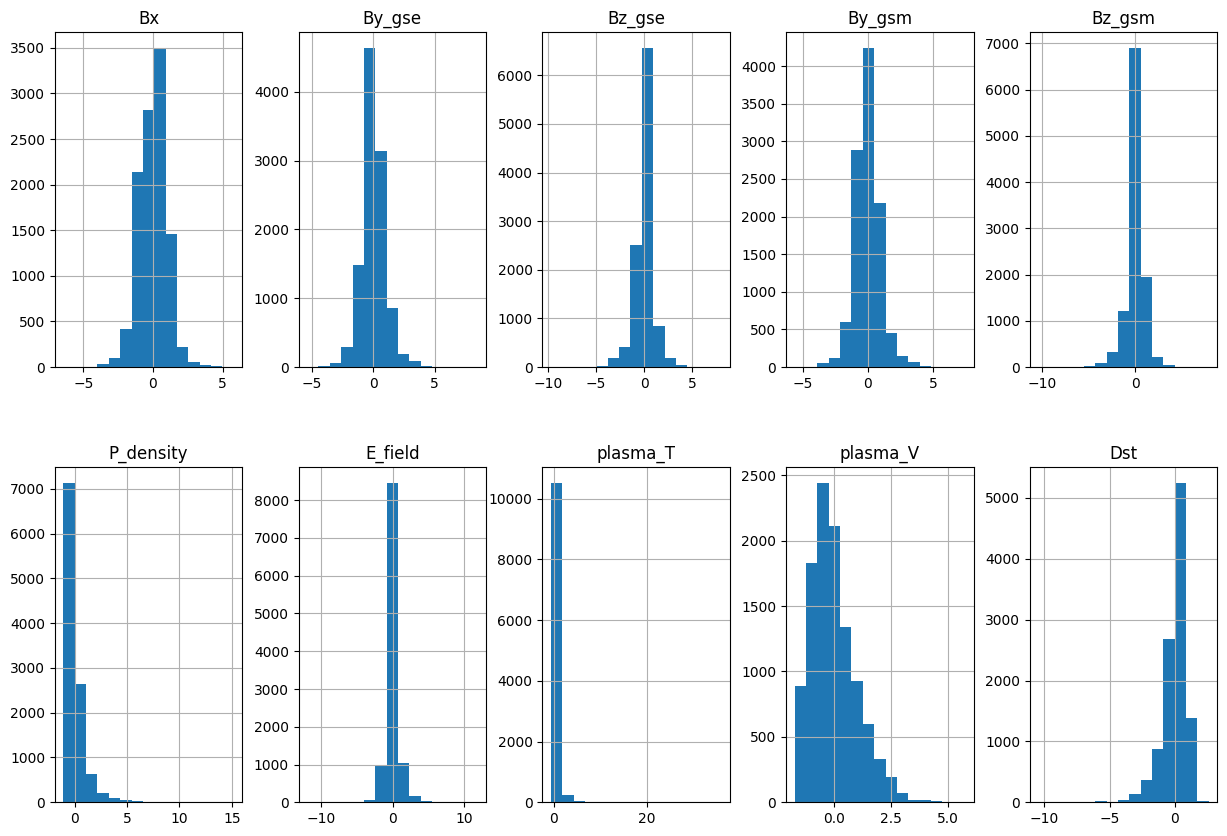

In [194]:
exploracion_histogramas(hd)

- Exploración de box-plots y violin-plots.

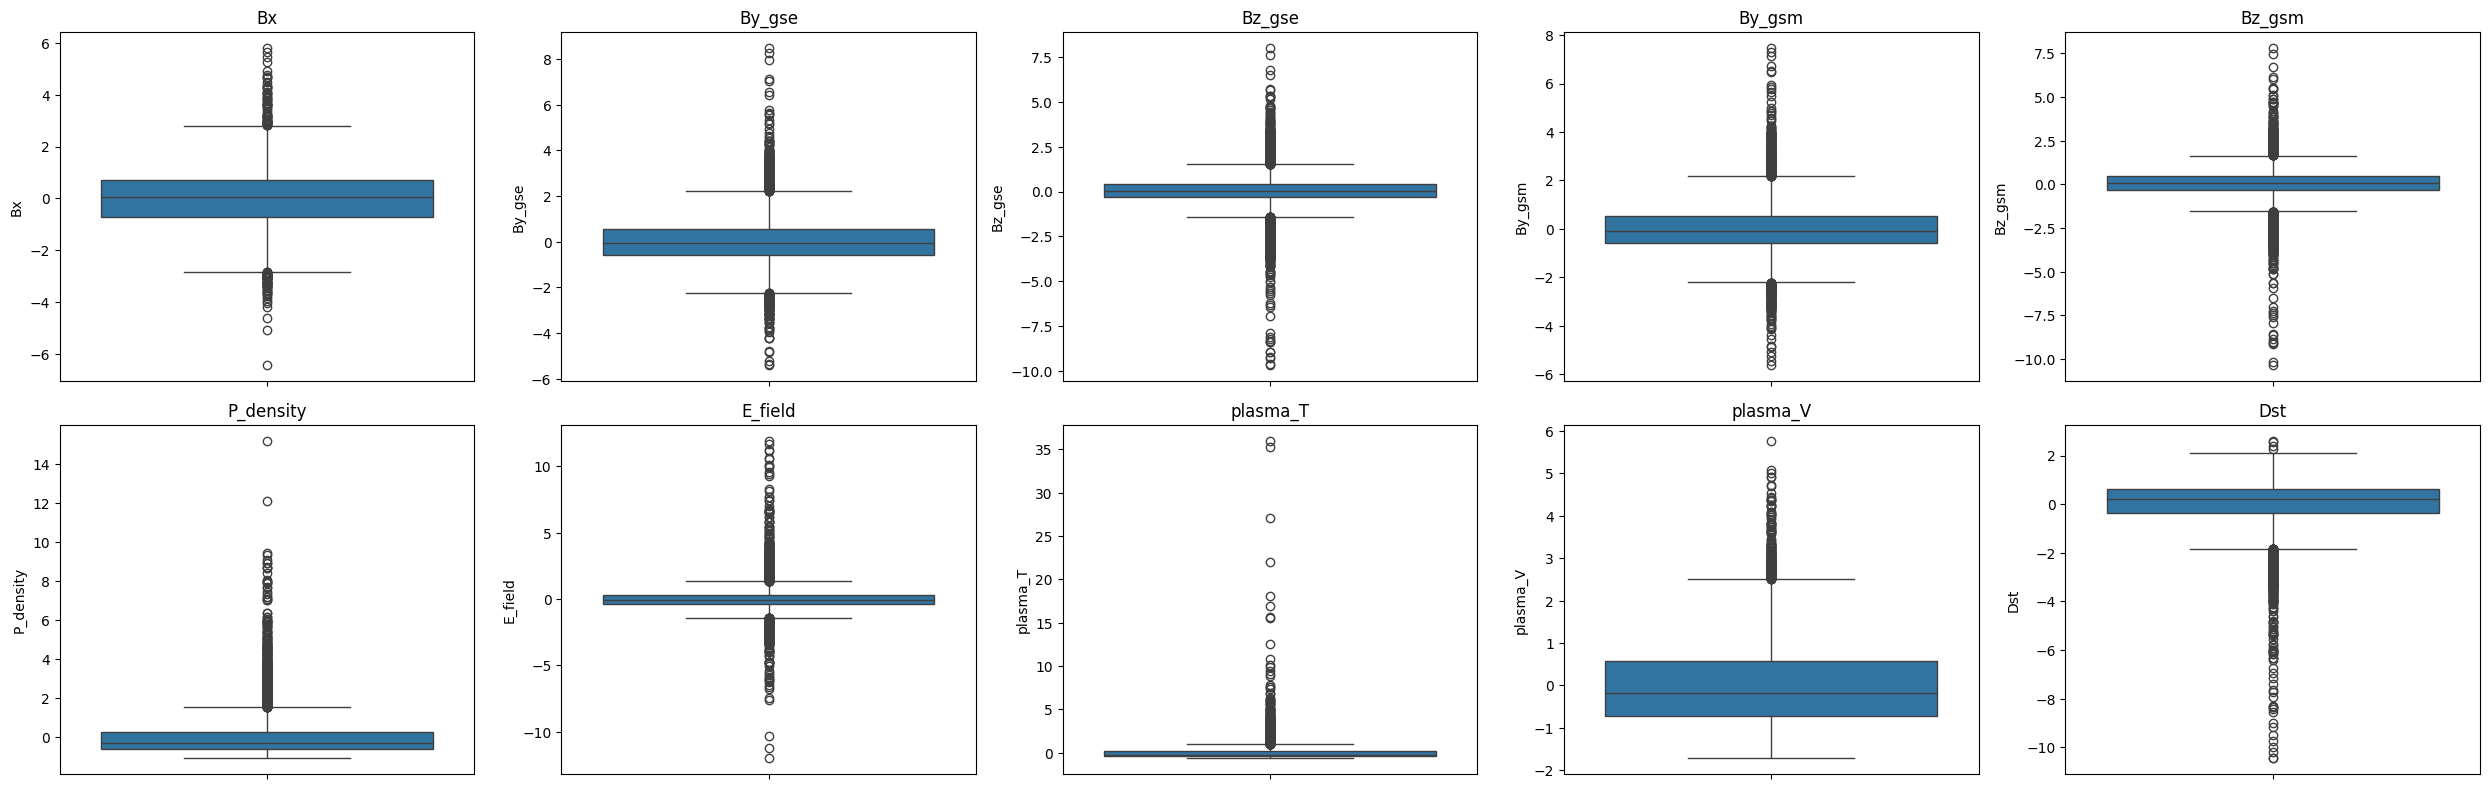

In [195]:
exploracion_boxplots(hd)

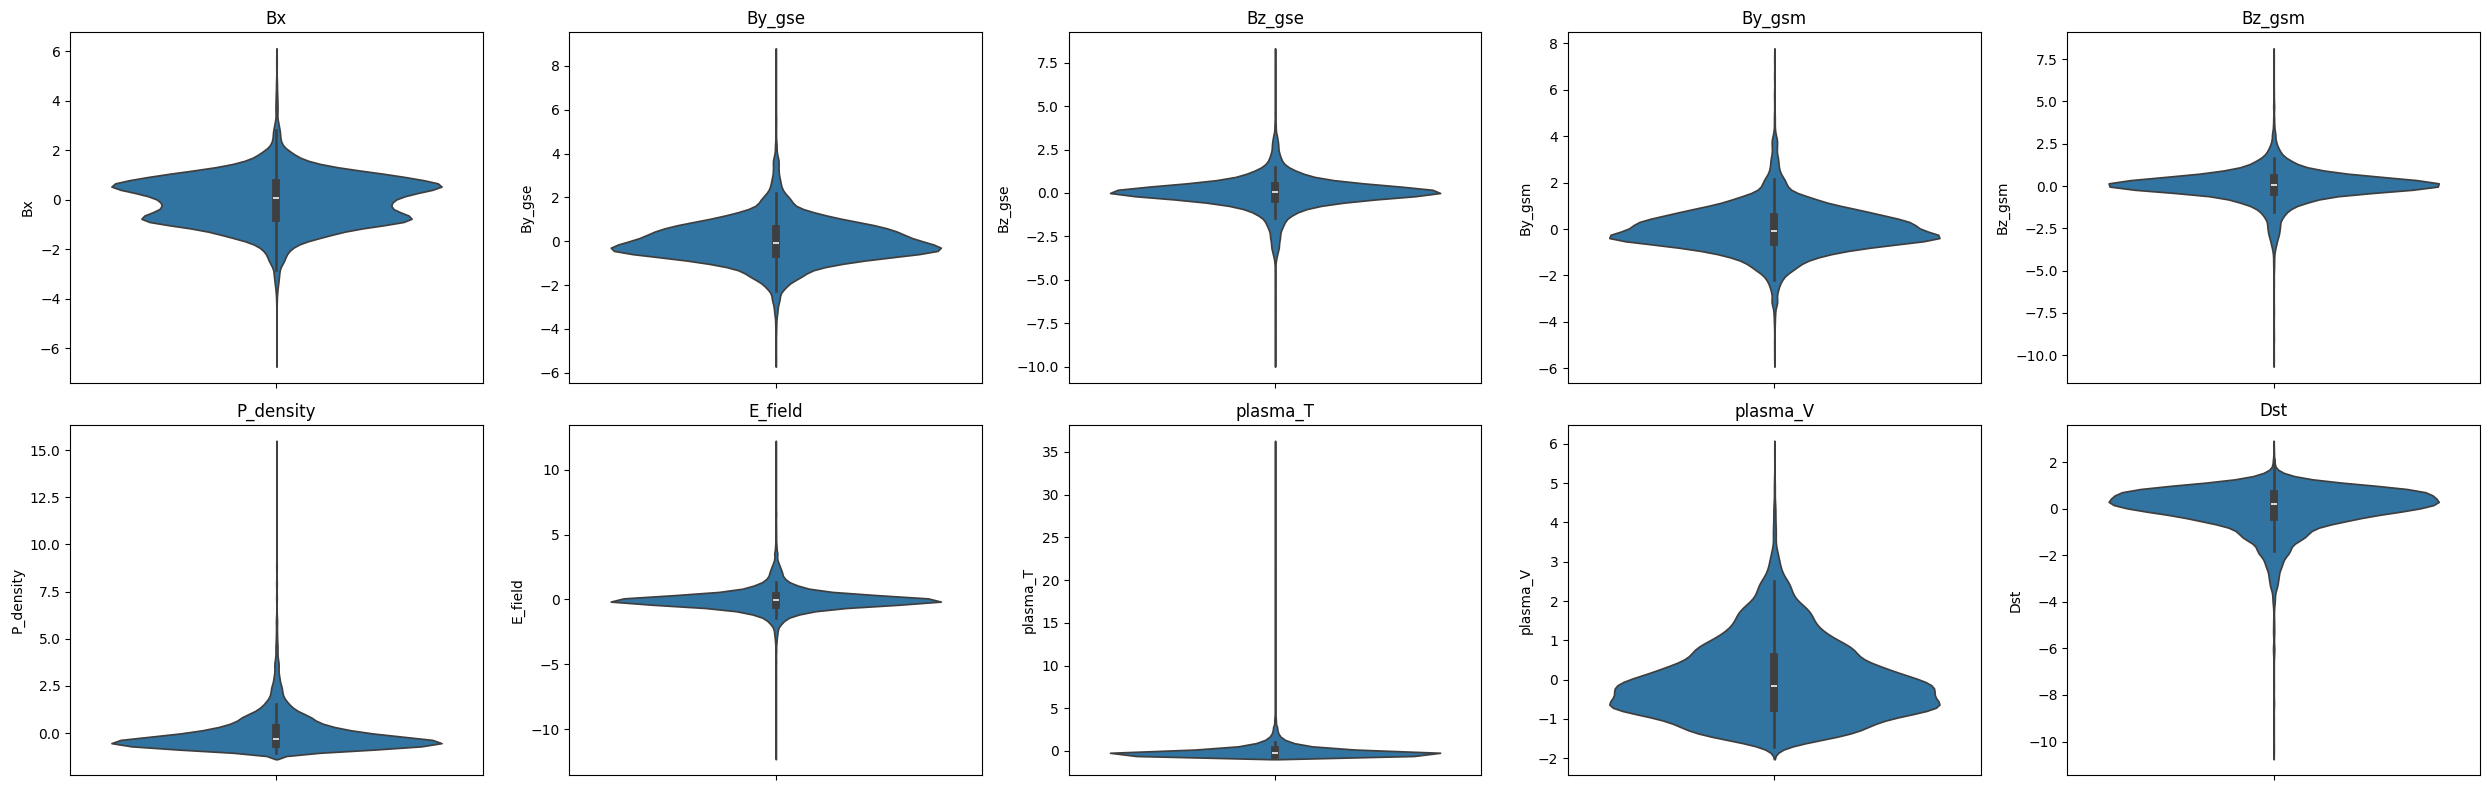

In [196]:
exploracion_violinplots(hd)

In [197]:
# prompt: I want a visualization complementary to exploracion_boxplots() and exploracion_violinplots()

def exploracion_pairplots(df):
    """
    Función para generar pair-plots para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Crear pair-plots
    sns.pairplot(df_numerico)
    plt.show()


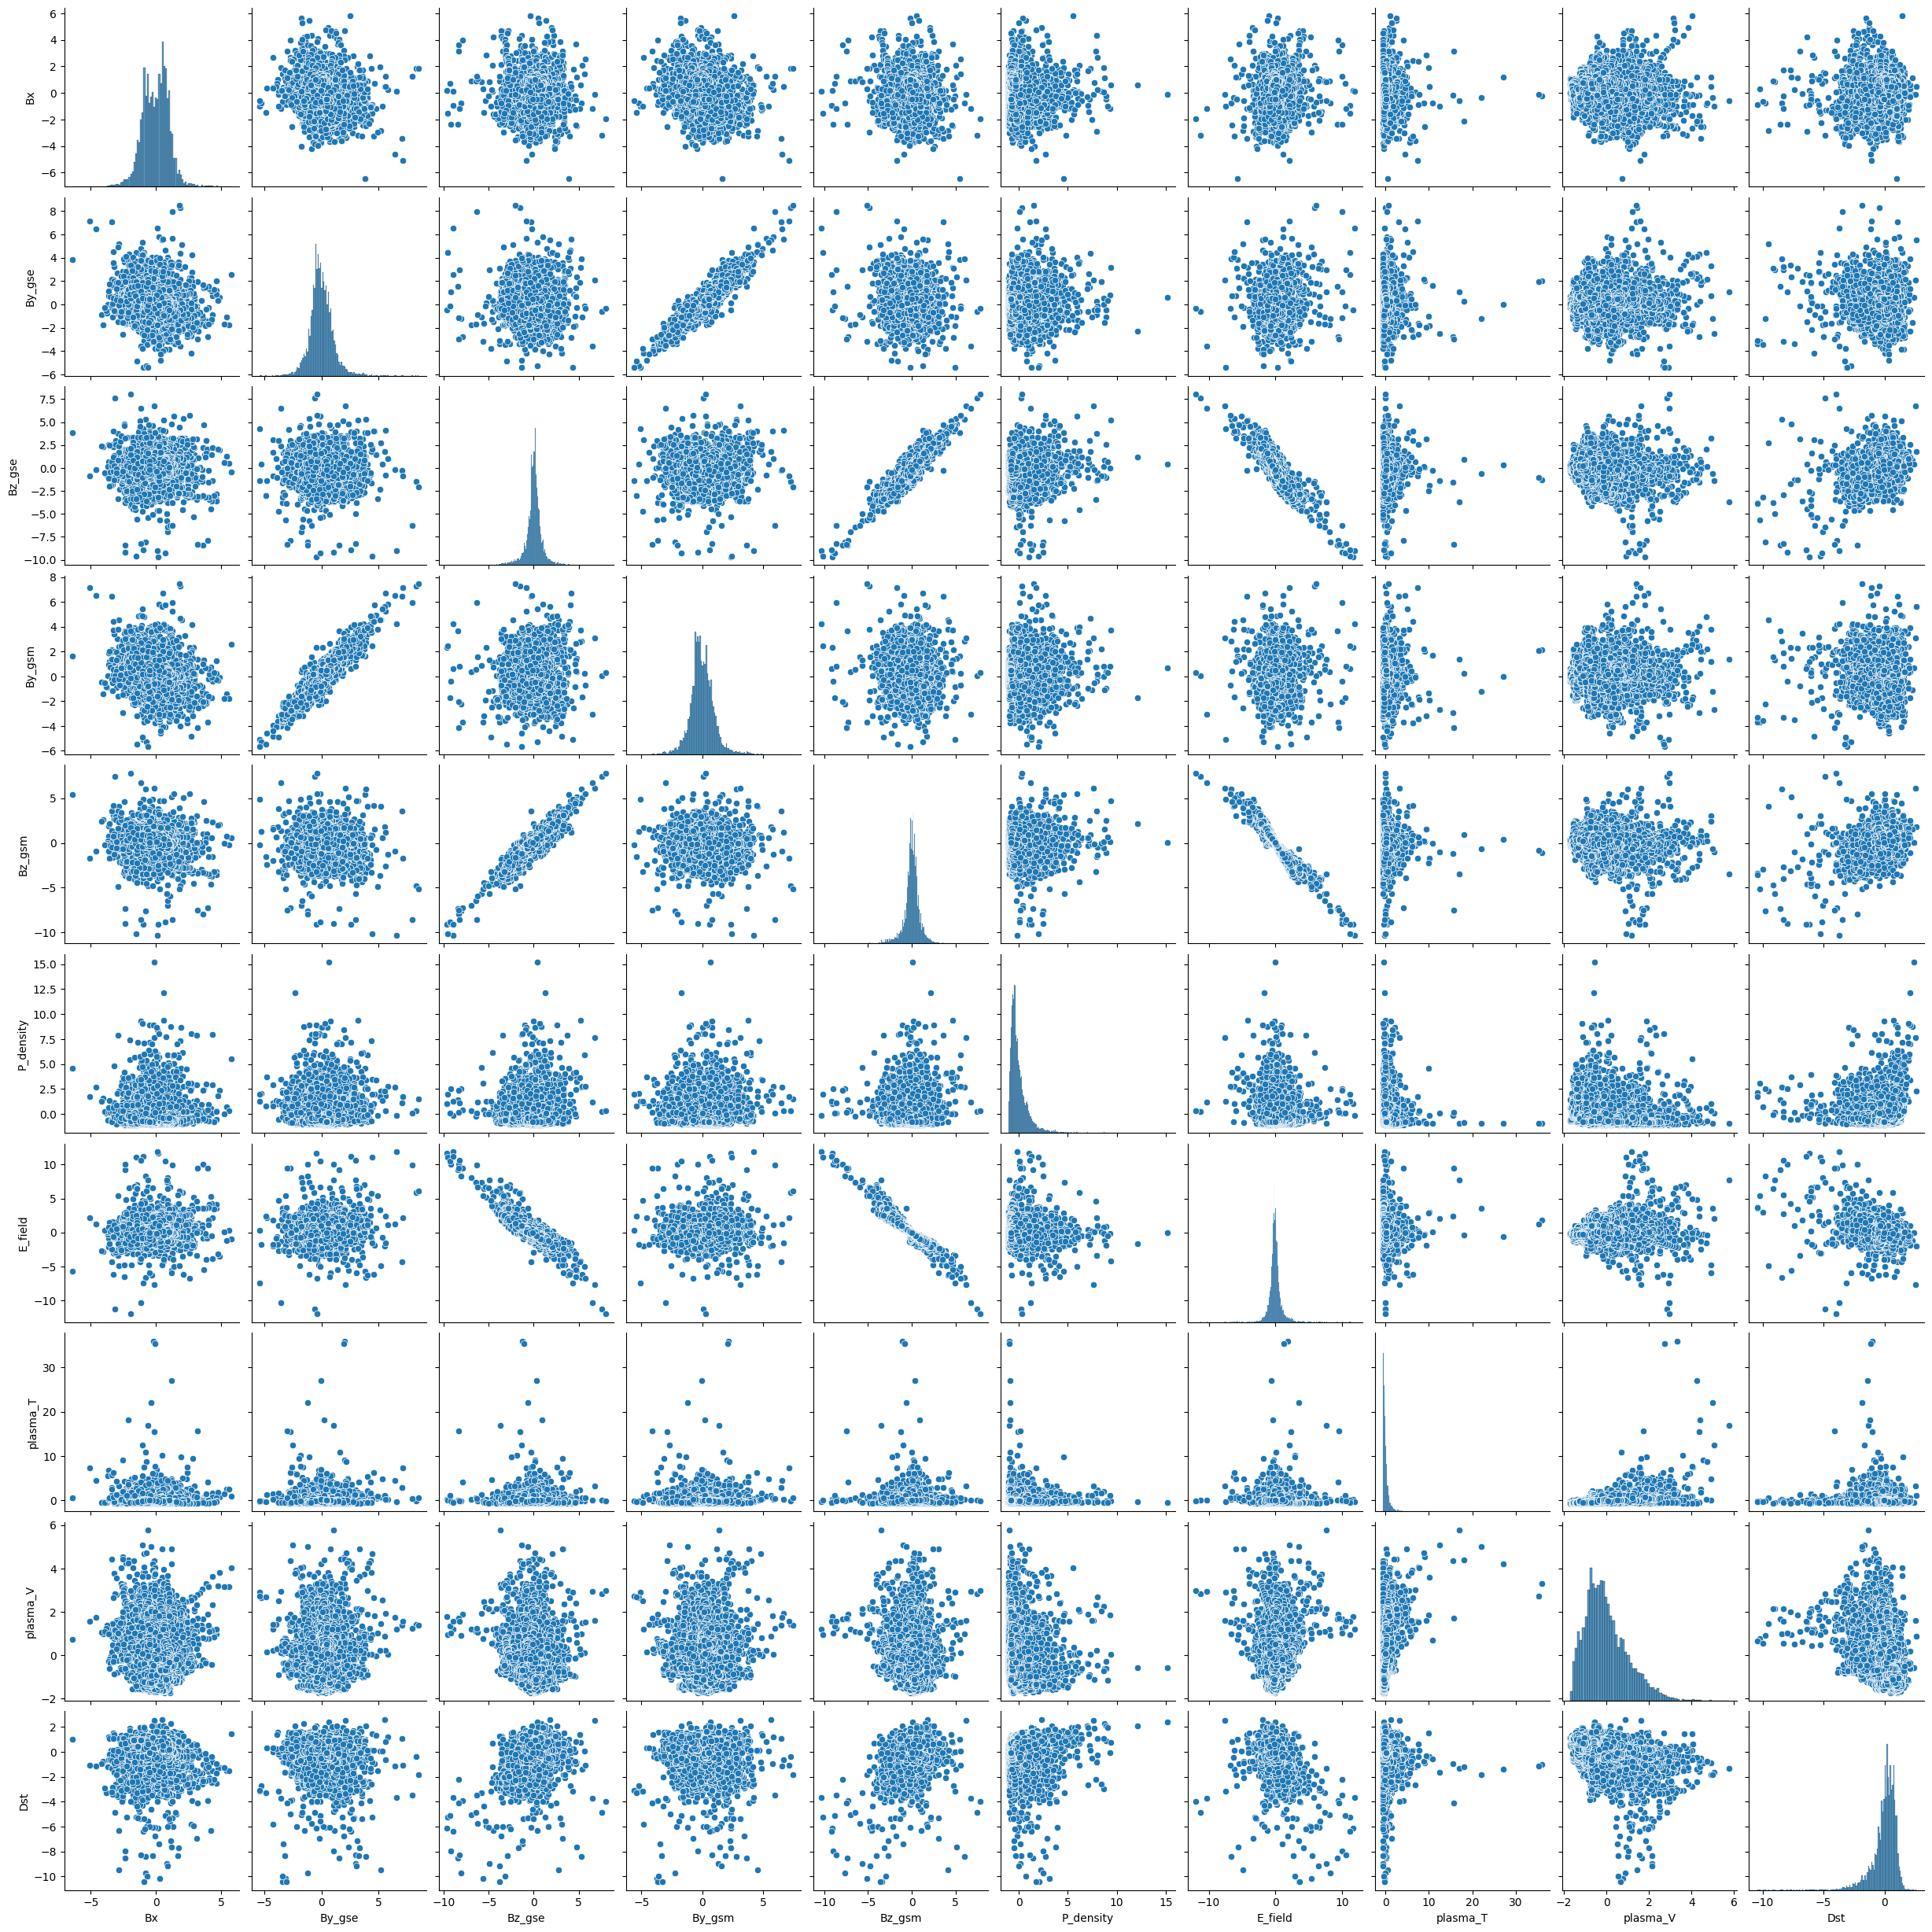

In [198]:
exploracion_pairplots(hd)

-  lineal positiva entre **By_gse** y **By_gsm**, **Bz_gse** y **Bz_gsm**, luego se ve que hay alta correlación entre estos pares.
- Las relaciones entre **E_field** y los componentes B_i, q8ue saldrá también en la correlación fuerte negativa.

- Visualizaciónd e historical_storms

In [199]:
storms_data = historical_storms.copy()

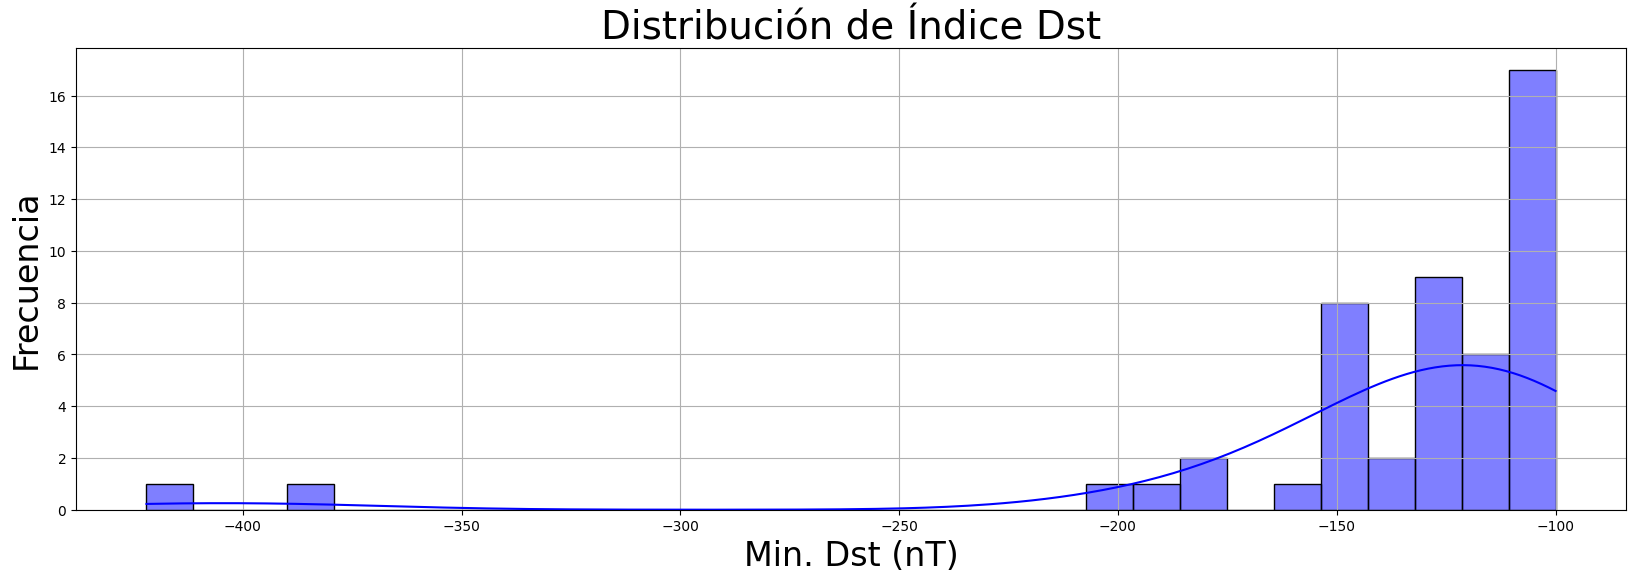

In [200]:
# Convertir las columnas de fecha y hora a datetime
storms_data['start'] = pd.to_datetime(storms_data['start'])
storms_data['end'] = pd.to_datetime(storms_data['end'])
# Calcular la duración de cada tormenta en horas
storms_data['duration_hours'] = (storms_data['end'] - storms_data['start']).dt.total_seconds() / 3600

# Gráfico de la distribución de las intensidades mínimas de las tormentas
plt.figure(figsize=(20,6))
sns.histplot(storms_data['Min. Dst (nT)'], bins=30, kde=True, color='blue')
plt.title('Distribución de Índice Dst', fontsize=28)
plt.xlabel('Min. Dst (nT)', fontsize=24)
plt.ylabel('Frecuencia', fontsize=24)
plt.grid(True)
plt.show()


- Lo esperado, pocas tormentas fuertes. Una se irá a train y otra a test.

- Ver el timeline de las tormentas

In [201]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Añadir cada tormenta como un segmento de línea en el gráfico
for i, row in storms_data.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['start'], row['end']],
        y=[i, i],
        mode='lines+markers',
        name=f"Tormenta {row['storm']}"
    ))

# Ajustar la presentación de la figura
fig.update_layout(
    title="Línea de Tiempo de Tormentas Históricas",
    xaxis_title="Fecha",
    yaxis_title="Tormenta",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(storms_data)))
    ),
    showlegend=False,
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# Mostrar la figura
fig.show()

Mapa de calor de la matriz de correlación

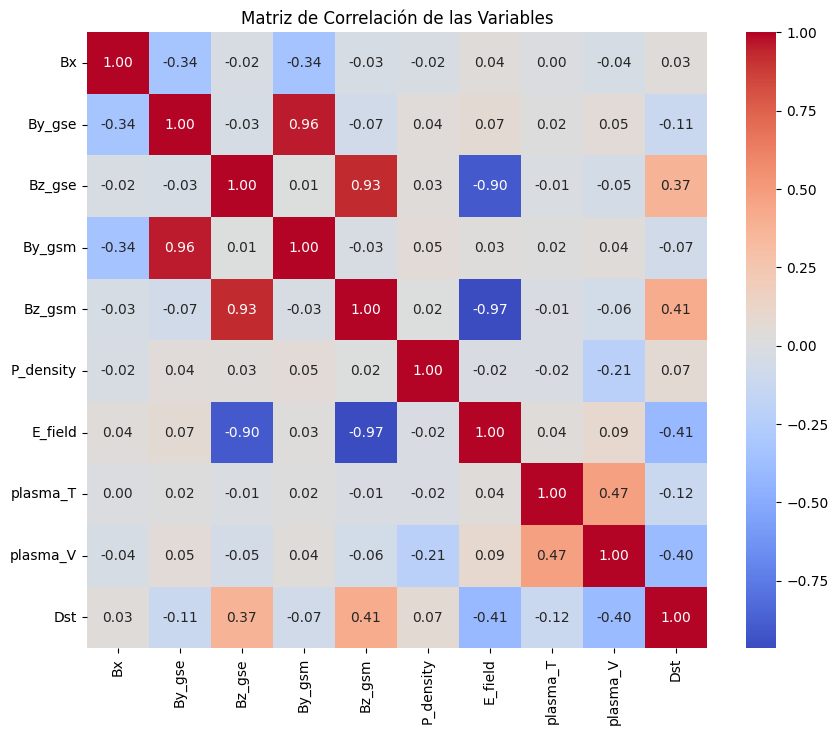

In [202]:
# Configuración del tamaño de la figura para la visualización de la correlación
plt.figure(figsize=(10, 8))

# Creando un heatmap para visualizar la matriz de correlación
sns.heatmap(hd.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación de las Variables')
plt.show()



- **By_gse y By_gsm** tienen una correlación muy alta, aka se comportan de manera muy similar.
- **Bz_gse y Bz_gsm** muy correlacionadas.
- **E_field** tiene una fuerte correlación negativa con **Bz_gse** y **Bz_gsm** --> a medida que el campo eléctrico aumenta,  Bz tiende a bahar.
- **Dst** muestra correlaciones moderadas con **Bz_gse (0.37)** y **Bz_gsm (0.41)**, lo que **podría ser relevante para entender su comportamiento en presencia de tormentas geomagnéticas**.

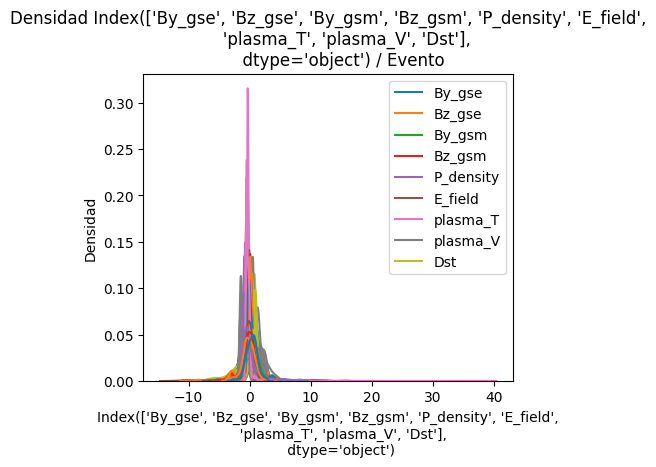

In [221]:
# Seleccionando datos para tres eventos específicos
events_to_plot = list(hd_by_storm["ID_STORM"].unique())
data_selected_events = hd_by_storm[hd_by_storm['ID_STORM'].isin(events_to_plot)]

# Configuración del tamaño de la figura para las visualizaciones de densidad
plt.figure(figsize=(20, 8))

# Visualización de densidad para cada variable y evento
for i, col in enumerate([hd_by_storm.columns[1:-1]]):
    plt.subplot(2, 5, i+1)
    for event in events_to_plot:
        sns.kdeplot(data_selected_events[data_selected_events['ID_STORM'] == event][col], label=f'Evento {event}')
    plt.title(f'Densidad {col} / Evento')
    plt.xlabel('{}'.format(col))
    plt.ylabel('Densidad')

plt.tight_layout()
plt.show()

- seleciconado las más interesnatres para el manuscrito

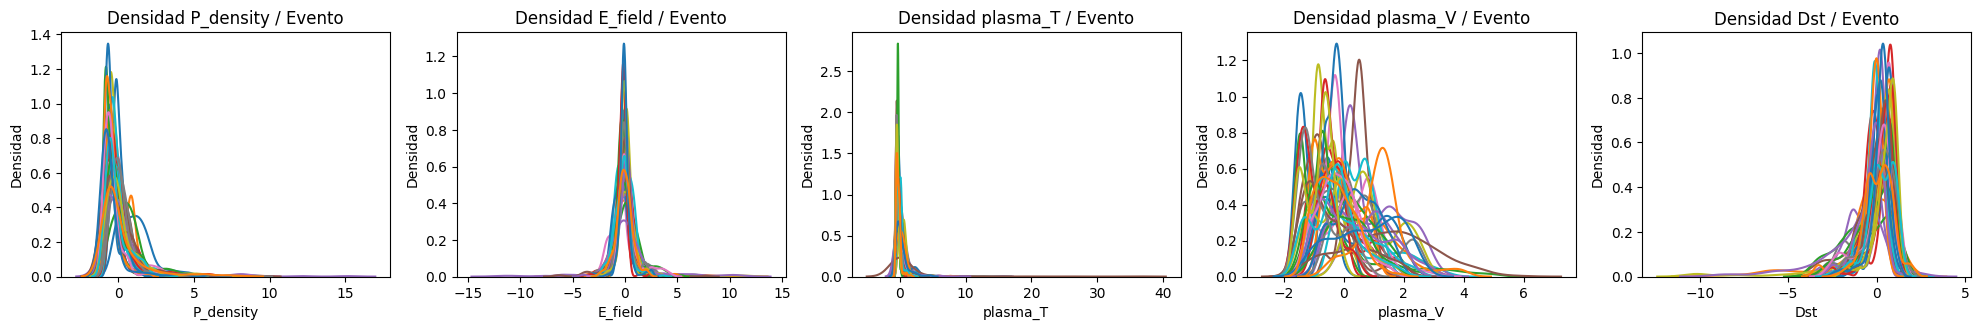

In [233]:
# Seleccionando datos para tres eventos específicos
events_to_plot = list(hd_by_storm["ID_STORM"].unique())
data_selected_events = hd_by_storm[hd_by_storm['ID_STORM'].isin(events_to_plot)]

# Columnas específicas a visualizar
cols_to_filter = ['P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst']

# Configuración del tamaño de la figura para las visualizaciones de densidad
plt.figure(figsize=(20, 6))

# Visualización de densidad para cada variable y evento
for i, col in enumerate(cols_to_filter):
    plt.subplot(2, 5, i + 1)
    for event in events_to_plot:
        sns.kdeplot(data_selected_events[data_selected_events['ID_STORM'] == event][col], label=f'Evento {event}')
    plt.title(f'Densidad {col} / Evento')
    plt.xlabel('{}'.format(col))
    plt.ylabel('Densidad')

plt.tight_layout()
plt.show()

**- No estoy muy convencida de esto!!**


- By_gse, Bz_gse, By_gsm, y Bz_gsm presentan distr normales centr en cero. en tormentas, fluctuar alrededor de un valor medio sin sesgos hacia ningun lado.
-  P_density y plasma_T colas largas, extremos en tormentas indican q la pueden aumentar llegar a condiciones más intensas.
- E_field tiene una variabilidad muy muy grande. SUpongo que esto indica lo dificil que es el fenómeno pero no sé cómo puede afectar a la predicción (???)
- plasma_V, es confusa pero parece que tiene "ondas" que se repiten, lo que puede indicar que existen diferentes modos de plasma que existen en tormentas y otros que no, es decir, diferentes fuentes / estados del plasma.

- Correlación (en el tiempo), añadimos desplazamiento.

In [204]:
shift=-2

In [210]:
def agg_by_storm(df_, window, shift_num): # Desplazamiento de la variable SYM_H para predecir su valor N horas después ({shift}} periodos de 1 hora)
    df = df_.copy()
    dfs_list = []
    for i in range(1,43):
        df_tmp = df[df["ID_STORM"]==i].copy()
        df_tmp['Dst_target'] = df_tmp['Dst'].shift(shift_num)
        df_tmp.dropna(inplace=True)

        # Calculando medias móviles, máximos, mínimos y desviación estándar para las variables seleccionadas usando la ventana definida
        features = cols_to_use
        for feature in features:
            df_tmp[f'{feature}_mean'] = df_tmp[feature].rolling(window=window, min_periods=window).mean()
            df_tmp[f'{feature}_max'] = df_tmp[feature].rolling(window=window, min_periods=window).max()
            df_tmp[f'{feature}_min'] = df_tmp[feature].rolling(window=window, min_periods=window).min()
            df_tmp[f'{feature}_std'] = df_tmp[feature].rolling(window=window, min_periods=window).std()

        # Eliminando filas con valores nulos que se crean debido a los cálculos de ventana y desplazamiento
        df_tmp = df_tmp.dropna().reset_index(drop=True)
        dfs_list.append(df_tmp)
    df_res = pd.concat(dfs_list)
    return df_res

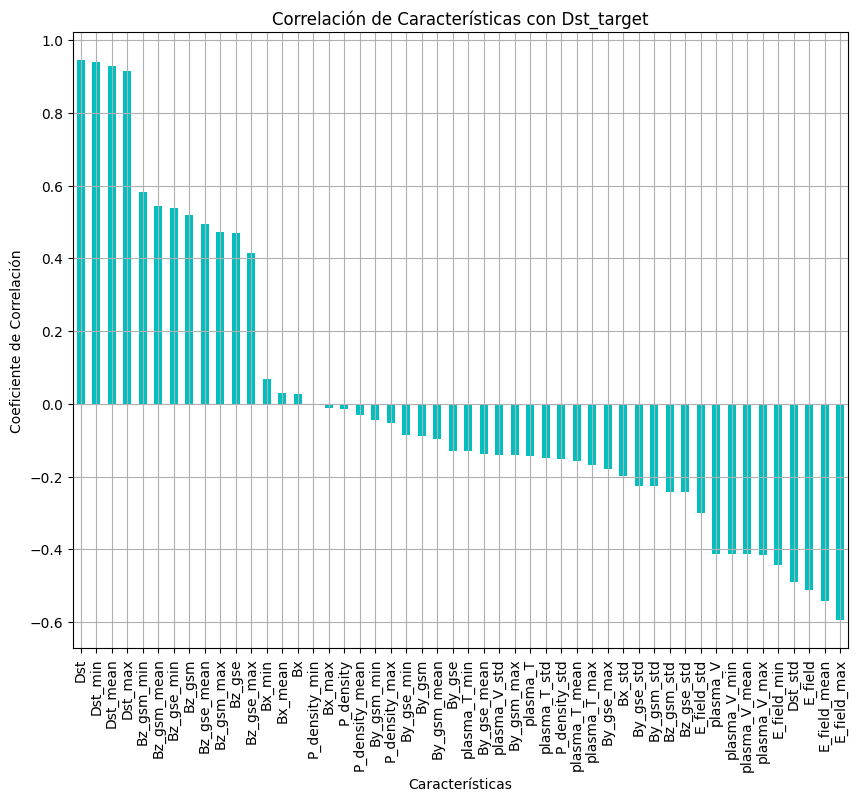

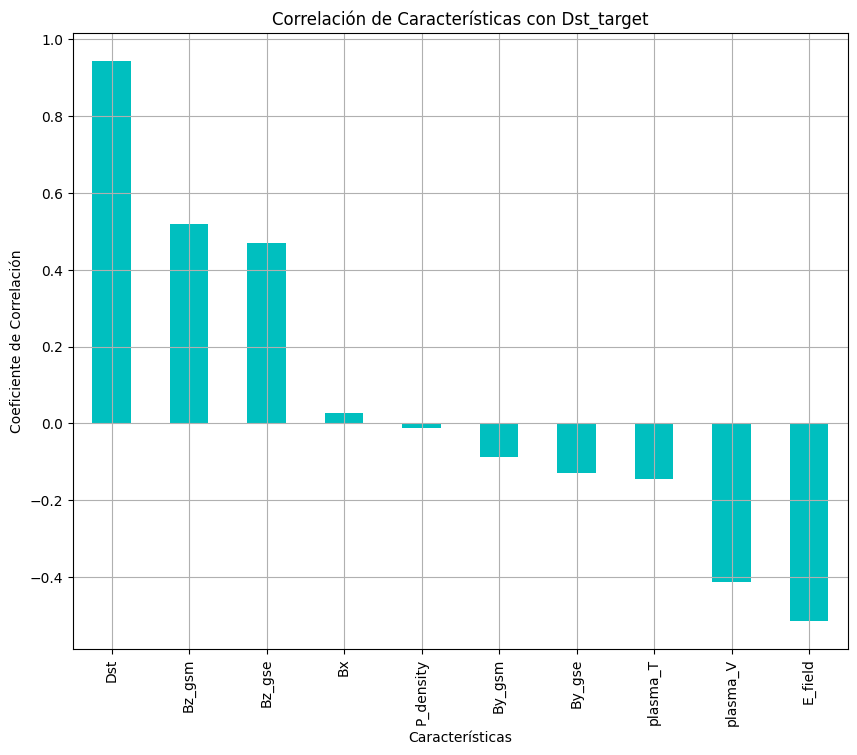

In [212]:
# Definiendo una ventana temporal de 2 hora (2 periodos de 1h)
window = 2

data_clean = agg_by_storm(hd_by_storm, window, shift)
correlation_target = data_clean[[col for col in data_clean.columns if col not in ['Datetime', 'ID_STORM']]].corr()['Dst_target']

# Ordenar las correlaciones para visualizar las más fuertes
correlation_target_sorted = correlation_target.sort_values(ascending=False)

# Visualizar las correlaciones más fuertes con Dst_target
plt.figure(figsize=(10, 8))
correlation_target_sorted.drop('Dst_target').plot(kind='bar', color='c')
plt.title('Correlación de Características con Dst_target')
plt.xlabel('Características')
plt.ylabel('Coeficiente de Correlación')
plt.grid(True)
plt.show()

features = cols_to_use_shift
correlation_target = data_clean[[col for col in features if col not in ['Datetime', 'ID_STORM']]].corr()['Dst_target']
# Ordenar las correlaciones para visualizar las más fuertes
correlation_target_sorted = correlation_target.sort_values(ascending=False)
# Visualizar las correlaciones más fuertes con Dst_target
plt.figure(figsize=(10, 8))
correlation_target_sorted.drop('Dst_target').plot(kind='bar', color='c')
plt.title('Correlación de Características con Dst_target')
plt.xlabel('Características')
plt.ylabel('Coeficiente de Correlación')
plt.grid(True)
plt.show()